<a href="https://colab.research.google.com/github/WittmannF/DL-plagiarism-detector/blob/master/Plagiarism_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1. TODO: Import any additional packages
from keras.models import Sequential
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50

TARGET_SHAPE = (224, 224, 3)

# 2. TODO: Initialize base model
base_model = ResNet50(include_top=False, input_shape=TARGET_SHAPE)

# 3. TODO: Freeze layers from the base model
for layer in base_model.layers:
    layer.trainable=False
    
# 4. TODO: Add Fully connected layer to the base model
model = Sequential([base_model,
                    GlobalAveragePooling2D()])

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [0]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [4]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
import numpy as np
import requests
from io import BytesIO
from PIL import Image

In [0]:
URLS = ['https://upload.wikimedia.org/wikipedia/commons/6/66/An_up-close_picture_of_a_curious_male_domestic_shorthair_tabby_cat.jpg',
        'https://images.pexels.com/photos/20787/pexels-photo.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/9/9e/Tabby_cat-3337027.jpg',
        'https://images.pexels.com/photos/162349/dog-hybrid-animal-lying-162349.jpeg',
        'https://images.pexels.com/photos/356378/pexels-photo-356378.jpeg']

target_shape=(224,224)

In [0]:
def read_img_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_shape)
    return img

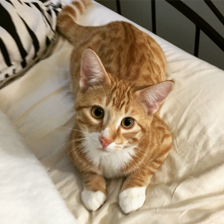

In [13]:
img = read_img_url(URLS[0]); img

In [0]:
from keras.applications.resnet50 import preprocess_input

def preprocess_img(img):
    # Convert to a Numpy array
    img_np = np.asarray(img)

    # Reshape by adding 1 in the beginning to be compatible as input of the model
    img_np = img_np[None] # https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#numpy.newaxis

    # Prepare the image for the model
    img_np = preprocess_input(img_np)
    
    return img_np

In [0]:
img_np = preprocess_img(img)

In [0]:
result = model.predict(img_np)

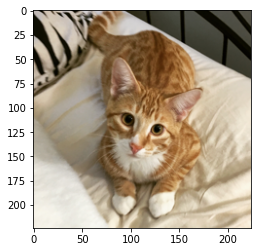

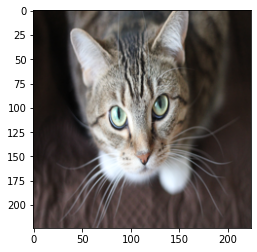

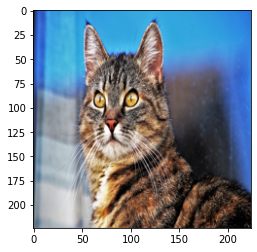

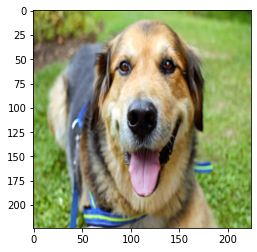

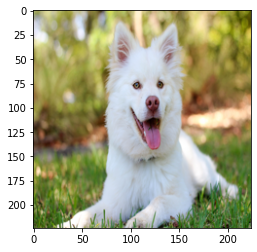

In [26]:
import matplotlib.pyplot as plt

all_features = []

for url in URLS:
    img = read_img_url(url)
    plt.imshow(img)
    plt.show()
    img_np = preprocess_img(img)
    result = model.predict(img_np)
    all_features.append(result[0])

In [29]:
import pandas as pd

df = pd.DataFrame(all_features); df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.042308,0.168865,0.034707,0.282211,0.273753,0.063503,0.329372,0.401481,0.299975,0.019311,0.287234,0.187533,0.334624,0.333550,0.177318,0.121659,0.012154,0.026436,0.153946,0.053217,0.072000,0.122551,0.042426,0.397307,0.481875,0.108170,0.311271,0.036436,0.057051,1.210866,0.201918,1.845439,0.014216,0.095395,2.725238,0.215707,0.093478,0.681401,0.012105,0.191334,...,0.000000,0.007023,1.158018,0.000000,0.945266,0.027128,0.397069,2.091383,0.159090,0.010994,0.000000,0.000000,0.000000,1.335536,0.037237,0.199467,0.469527,2.574245,0.231526,0.133946,0.595770,0.007868,0.194367,0.221116,2.208642,0.227523,0.418293,0.058154,0.000000,0.101071,0.023131,0.047329,0.000000,2.145496,0.043495,0.553697,0.151877,0.133250,0.027247,0.199385
1,0.025938,0.364023,0.002671,0.121978,0.157954,0.359916,0.182206,0.270348,0.000000,0.000000,0.000000,0.000000,0.069450,0.076153,0.024985,0.000000,0.122439,0.003567,0.273841,0.146902,0.249745,0.010659,0.000000,0.718277,0.014272,0.073362,0.616622,0.016031,0.000000,0.000000,0.203763,0.164111,0.007428,0.161543,0.511678,0.082609,0.003743,0.784711,0.805828,0.216602,...,0.191724,0.000000,0.610750,0.037134,0.000000,0.142060,0.310176,0.196507,0.939605,0.227696,0.000000,0.000000,0.002796,1.779072,0.001015,0.358017,0.281408,0.040701,0.002146,0.004344,0.281539,0.000000,0.166622,0.000000,0.330221,0.000000,0.078642,0.373150,0.091342,0.284855,0.010499,0.384191,0.037875,0.991623,0.001638,0.066376,0.583706,0.000000,0.022262,0.158811
2,0.315768,0.049677,0.072736,0.029473,0.194881,0.000000,0.263104,0.378804,0.000000,0.199715,0.009670,0.006166,0.466496,0.006648,0.154985,0.000000,0.135079,0.000000,0.157396,0.202456,0.000000,0.133431,0.000000,0.295435,0.197056,0.015042,0.119953,0.126033,0.004000,0.079121,0.114987,1.128978,0.000000,0.032939,0.542522,0.125414,0.000000,1.011145,0.591465,0.171527,...,0.224916,0.065314,0.857295,0.229519,0.187825,0.000000,0.240743,1.117852,0.074505,0.152508,0.486728,0.009316,0.000000,0.013623,0.982027,0.008490,1.910821,0.034408,0.073114,0.026375,0.725586,0.063366,0.339266,0.024320,0.436376,0.000000,0.000000,0.004838,0.000000,0.092685,0.075172,0.000000,0.337389,0.343541,0.165771,0.064158,1.313954,0.000000,0.140156,0.000000
3,0.439888,0.076697,0.012772,0.000000,0.019944,2.500911,0.270587,0.403028,0.007690,0.442542,0.045540,0.015771,2.599114,0.275431,0.000000,0.239130,0.000000,0.935476,0.125230,0.034047,1.543936,0.054890,0.371684,0.599665,0.098614,0.008500,0.006772,0.885238,0.000000,0.404353,0.702676,0.135913,0.037729,0.711778,0.033072,0.015717,0.000000,0.158277,0.535844,0.376901,...,0.054220,1.173569,0.089450,0.075139,0.637120,0.047043,0.308179,0.101238,0.168777,0.141622,0.018883,0.054504,0.054495,0.000000,0.180436,0.036910,0.266209,0.181483,0.070275,1.340660,0.627921,0.000000,0.042656,0.264619,0.065561,0.062744,0.612002,0.014584,0.410401,0.041458,0.334218,0.394886,0.010589,0.031647,0.210968,0.191819,0.093776,0.113848,0.268616,0.283168
4,0.537157,0.219324,0.081363,0.416222,0.124936,0.204497,0.000000,0.067160,0.214189,0.214841,0.030703,0.094725,0.466140,0.000000,0.010587,0.000000,0.000000,1.118436,0.246646,0.000000,0.000000,0.001567,0.524867,0.302005,0.050315,0.293311,0.014463,0.079879,0.081266,0.056639,1.059674,0.622229,0.209047,0.665587,0.173117,0.009413,0.000000,0.152467,2.043540,0.000000,...,1.114734,0.481417,1.034750,0.000000,0.000000,0.468662,0.016597,0.653945,0.082562,0.000000,0.012267,0.127353,0.095275,0.056274,0.328922,0.082574,2.399606,0.000000,0.000000,2.954933,0.321786,0.000000,0.351217,0.000000,1.912971,0.000428,0.085345,0.021195,0.000000,0.230685,0.182890,0.797268,0.059969,0.548853,0.126000,0.106490,1.265144,0.023760,0.515167,0.064750


## PCA

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
reduced_data = pca.transform(df)

In [0]:
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [34]:
reduced_data

,Dimension 1,Dimension 2
0,-10.871898,17.540184
1,-13.253351,-6.396704
2,-9.605894,-11.273940
3,17.588707,-3.101003
4,16.142435,3.231463


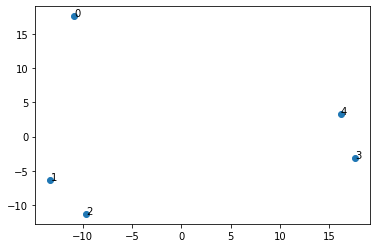

In [42]:
plt.scatter(reduced_data['Dimension 1'], reduced_data['Dimension 2'])

for item in reduced_data.itertuples():
    plt.annotate(item[0], (item[1], item[2]))
    

### Conclusion
The X Axis turned to be what differentiates dogs and cats. Apparently dogs will be in the right and cats in the left. The Y axis seems to be related to the color, since cat at index 0 has a different color when compared to the cat at index 1 and 2. This can also be confirmed because cat at index 1 has a very similar color to the dog at index 3. 